In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json
/kaggle/input/wiki-words/tensorflow2/500-with-normalization/1/saved_model.pb
/kaggle/input/wiki-words/tensorflow2/500-with-normalization/1/assets/tokens.txt
/kaggle/input/wiki-words/tensorflow2/500-with-normalization/1/variables/variables.index
/kaggle/input/wiki-words/tensorflow2/500-with-normalization/1/variables/variables.data-00000-of-00001


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import os
import re
import nltk
import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# Download stopwords if not already downloaded
nltk.download('stopwords')
# Get the list of stopwords
stop_words = set(stopwords.words('english'))

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_34/2485143377.py:12: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [3]:
df = pd.read_json('/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [4]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [5]:
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [6]:
# drop columns like authors, links and date as they are irrelevent to our problem.
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [7]:
# Create the bar chart
fig = go.Figure([go.Bar(x=new_df["category"].value_counts().index, y=new_df["category"].value_counts().values)])

# Set title and axis labels
fig.update_layout(
    title={
        'text': 'Distribution of Articles by Category',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24, 'color': 'black', 'family': 'Arial'}
    },
    xaxis_title="Category Name",
    yaxis_title="Number of Articles",
    font=dict(
        family="Arial",
        size=14,
        color="black"
    )
)

# Set plot size and margins
fig.update_layout(
    width=800,
    height=600,
    margin=dict(l=50, r=50, t=100, b=50)
)

# Customize bar colors and hover text
fig.update_traces(
    marker=dict(color='rgb(63, 122, 204)'),  # Set bar color
    hovertemplate='Category: %{x}<br>Number of Articles: %{y}',  # Customize hover text
    textposition='outside'  # Set label position outside the bars
)

# Customize axes appearance
fig.update_xaxes(
    tickangle=45,  # Rotate x-axis labels
    tickfont=dict(family='Arial', size=12),
    showgrid=False  # Hide the gridlines
)
fig.update_yaxes(
    tickfont=dict(family='Arial', size=12),
    showgrid=True,  # Show the y-axis gridlines
    gridcolor='lightgray',  # Set gridline color
    gridwidth=0.5  # Set gridline width
)

# Set background color and plot border
fig.update_layout(
    plot_bgcolor='white',  # Set background color
    paper_bgcolor='white',  # Set plot border color
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [8]:
# Calculate the top 10 categories and their respective counts
top_categories = new_df['category'].value_counts().nlargest(10)

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=top_categories.index, values=top_categories.values)])

# Set title
fig.update_layout(
    title={
        'text': 'Top 10 Categories',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24, 'color': 'black', 'family': 'Arial'}
    }
)

# Customize pie slice colors
colors = ['rgb(63, 122, 204)', 'rgb(255, 128, 0)', 'rgb(255, 0, 0)', 'rgb(0, 153, 0)',
          'rgb(204, 51, 255)', 'rgb(255, 204, 0)', 'rgb(0, 204, 204)', 'rgb(153, 51, 0)',
          'rgb(51, 51, 255)', 'rgb(204, 0, 204)']
fig.update_traces(
    marker=dict(colors=colors)
)

# Set background color and plot border
fig.update_layout(
    plot_bgcolor='white',  # Set background color
    paper_bgcolor='white',  # Set plot border color
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [9]:
# create final dataframe of combined headline and short_description
final_df = new_df.copy()
final_df['news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['news'].map(lambda x: len(x))
final_df.head()

,category,news,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233


In [10]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df

,category,len_news
24,POLITICS,1486
41,WORLDPOST,1424
4,COLLEGE,1225
16,HEALTHY LIVING,1073
38,WELLNESS,1036
34,TRAVEL,978
3,BUSINESS,950
30,STYLE & BEAUTY,870
15,GREEN,856
18,IMPACT,844


In [11]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df

,category,len_news
35,U.S. NEWS,73
8,DIVORCE,66
33,THE WORLDPOST,56
36,WEDDINGS,54
21,MONEY,51
40,WORLD NEWS,51
11,ENVIRONMENT,50
1,ARTS & CULTURE,47
13,FOOD & DRINK,27
22,PARENTING,27


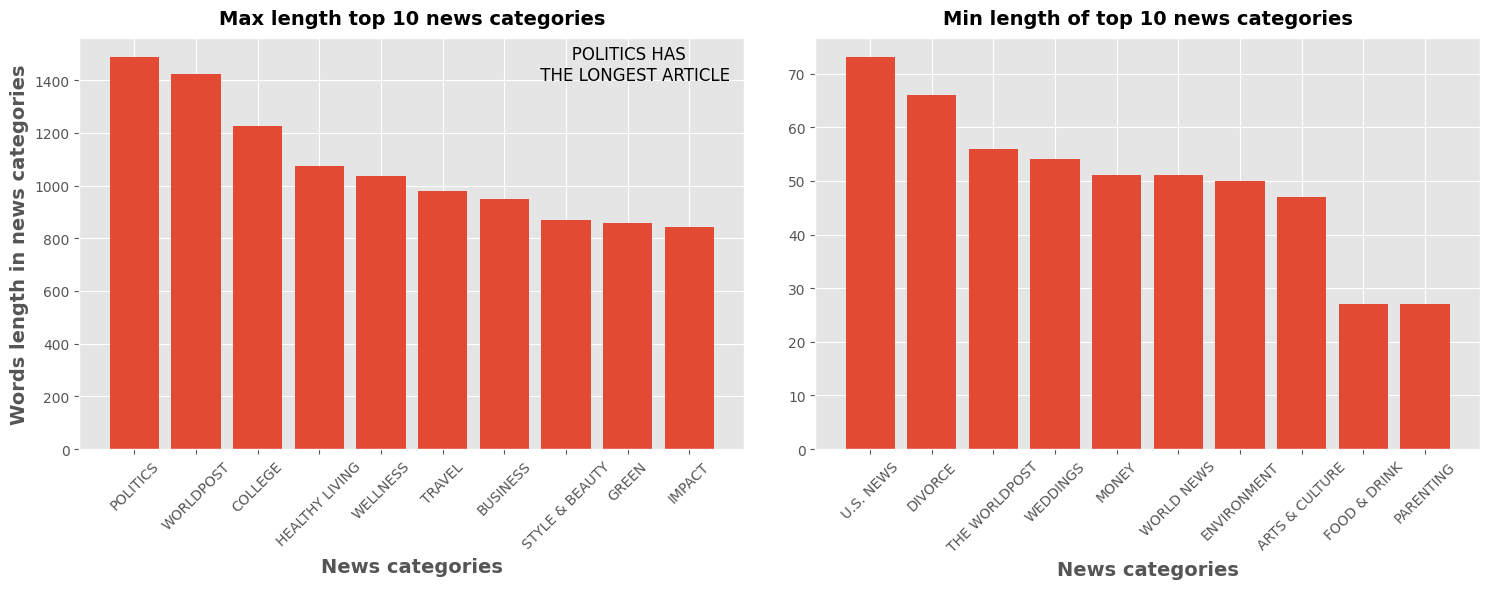

In [12]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS 
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

In [13]:
# Top categories by number of articles per categories
cat_df = pd.DataFrame(new_df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)
cat_df

,news_classes,numcat
0,POLITICS,35602
1,WELLNESS,17945
2,ENTERTAINMENT,17362
3,TRAVEL,9900
4,STYLE & BEAUTY,9814
5,PARENTING,8791
6,HEALTHY LIVING,6694
7,QUEER VOICES,6347
8,FOOD & DRINK,6340
9,BUSINESS,5992


In [14]:
# create new dataframe of category and length of each news articles in that categories
news_and_headline = final_df.copy()
news_and_headline.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in our dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = news_and_headline[news_and_headline['category'] == i]
    cat_array = cat_ndf['news'].values  # array of news articles text in each category
    articles_list.append(cat_array)
    

In [15]:
news_and_headline

,category,news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,PARENTING,The Funniest Tweets From Parents This Week (Se...
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...
...,...,...
209522,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
209523,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...
209524,SPORTS,"Giants Over Patriots, Jets Over Colts Among M..."
209525,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

def preprocess_text(text):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Convert text to lowercase
    text = text.lower()

    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Lemmatize the tokens and remove stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text


In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(embeddings1, embeddings2):
    # Calculate cosine similarity between two sets of embeddings
    similarity_matrix = cosine_similarity(embeddings1, embeddings2)

    # Return the row-wise similarity scores
    similarity_scores = np.diag(similarity_matrix)

    return similarity_scores


In [18]:
news_and_headline['news'][0]

'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID BoostersHealth experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.'

In [21]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [22]:
preprocess_text(news_and_headline['news'][0])

'million american roll sleeve omicrontargeted covid boostershealth expert said early predict whether demand would match million dos new booster u ordered fall'

In [23]:
# creating a new dataframe
politics_list = list(news_and_headline[news_and_headline['category'] == 'POLITICS'].index) 
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

# drop these 16000 labels from the dataset
transformed_df = news_and_headline.copy()
transformed_df.drop(list_16, axis=0, inplace=True)

In [24]:
# apply datacleaning function to column 'length_of_news'
transformed_df['news'] = transformed_df['news'].apply(preprocess_text)

In [35]:
len(transformed_df['category'].unique())

42

In [46]:
# one hot encoding using keras tokenizer and pad sequencing
X = transformed_df['news']
encoder = LabelEncoder()
y = encoder.fit_transform(transformed_df['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=130) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 130 # max length of sequence 
y_train = to_categorical(y_train, num_classes=42)
y_test = to_categorical(y_test, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (193527,)
shape of target variable:  (193527,)
Length of word index: 182654


In [39]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=maxlen))
model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Conv1D(72, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 130, 100)          18251300  
                                                                 
 bidirectional_6 (Bidirectio  (None, 130, 128)         84480     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 130, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 130, 128)         24704     
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 72)           27720     
                                                      

In [47]:
train_padseq.shape

(154821, 130)

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train, 
                     batch_size=128, 
                     epochs=15, 
                     validation_split=0.2,
                     shuffle=True
                    )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
968/968 [==============================] - 1362s 1s/step - loss: 3.2136 - accuracy: 0.2538 - val_loss: 2.4751 - val_accuracy: 0.3654
Epoch 2/15
968/968 [==============================] - 1353s 1s/step - loss: 2.2285 - accuracy: 0.4306 - val_loss: 2.0383 - val_accuracy: 0.4800
Epoch 3/15
968/968 [==============================] - 1351s 1s/step - loss: 1.8792 - accuracy: 0.5167 - val_loss: 1.9434 - val_accuracy: 0.5043
Epoch 4/15
968/968 [==============================] - 1348s 1s/step - loss: 1.6879 - accuracy: 0.5644 - val_loss: 1.8634 - val_accuracy: 0.5255
Epoch 5/15
968/968 [==============================] - 1357s 1s/step - loss: 1.5369 - accuracy: 0.6016 - val_loss: 1.8651 - val_accuracy: 0.5296
Epoch 6/15
968/968 [==============================] - 1342s 1s/step - loss: 1.4145 - accuracy: 0.6332 - val_loss: 1.8858 - val_accuracy: 0.5269
Epoch 7/15
968/968 [==============================] - 1337s 1s/step - loss: 1.3109 - accuracy: 0.6616 - val_loss: 1.8860 - val_accuracy:

In [ ]:
model.save("new_clf_exp06.h5")

In [ ]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

In [ ]:
plot_loss_accuracy(history)